In [4]:
import os
import cv2
import math
import random
import torch
import einops
import numpy as np
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import matplotlib.pyplot as plt
import torch.nn.functional as FF

In [5]:
P = [.05, .1, .2, .05, .15, .25, .08, .12]
Q = [.3, .1, .2, .1, .1, .02, .08, .1]

from scipy.special import rel_entr

sum(rel_entr(P, Q))

0.589885181619163

In [6]:
# 0 - не требует переворотов
# 1 - cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
names = {
    "QR_Тест_ТЕСТОВОЕ_ ТЕСТВО_[НВ_2 оч_13 ж.д.]_1_9_118_XXXxxx_07-10-23_ot.mp4": 0,
    "QR_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_11_118_AzPmRG_21-10-23_decor.mp4": 1,
    "QR_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_9_118_qoY4P8_07-10-23_decor.mp4": 1,
    "QR_Москва_ОСТАФЬЕВО_[ОСТ_4 оч_13 ж.д.]_5_9_126_lxMLNd_14-10-23_decor.mp4": 1,
    "QR_Тестовая обл._ТЕСТ ТЕСТОВОЕ_[ПЛ_6 оч_1 эт_8.1 ж.д.]_1_9_127_B032TF_06-10-23_ot.mp4": 0,
    "Москва_ОСТАФЬЕВО_12.3_2_3-1KSipF_-23-02-23.mp4": 1,
    'Москва_ОСТАФЬЕВО_12.3_2_3-291rgq9-23-02-23.mp4': 1,
    'Москва_ОСТАФЬЕВО_12.3_2_3-3aeI6Lw-23-02-23.mp4': 1,
    'Москва_ОСТАФЬЕВО_12.3_2_3-41TezHv-23-02-23.mp4': 1,
    'Москва_ОСТАФЬЕВО_12.3_2_4-1XIdkZ7-23-02-23.mp4': 1,
    'Москва_ОСТАФЬЕВО_12.3_2_4-2DDlOz--23-02-23.mp4': 1,
    'Москва_ОСТАФЬЕВО_12.3_2_4-30O1k1_-23-02-23.mp4': 1,
    'QR_Московская обл._ПРИГОРОД ЛЕСНОЕ_[ПЛ_6 оч_1 эт_8.1 ж.д.]_1_17_127_bC2h95_21-10-23_decor.mp4': 1,
    'QR_Московская обл._ПРИГОРОД ЛЕСНОЕ_[ПЛ_6 оч_1 эт_8.1 ж.д.]_1_17_127_sIOFtt_14-10-23_decor.mp4': 1,
    'QR_Московская обл._ПРИГОРОД ЛЕСНОЕ_[ПЛ_6 оч_1 эт_8.1 ж.д.]_1_15_127_vvTUcu_21-10-23_decor.mp4': 1,
    'QR_Московская обл._ПРИГОРОД ЛЕСНОЕ_[ПЛ_6 оч_1 эт_8.1 ж.д.]_1_16_127_03lZK3_14-10-23_decor.mp4': 1,
    'QR_Московская обл._ПРИГОРОД ЛЕСНОЕ_[ПЛ_6 оч_1 эт_8.1 ж.д.]_1_16_127_Hb5hAo_21-10-23_decor.mp4': 1,
    'QR_Московская обл._ПРИГОРОД ЛЕСНОЕ_[ПЛ_6 оч_1 эт_8.1 ж.д.]_1_16_127_gAkOyd_30-10-23_decor.mp4': 1,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_1_117_0vAQQ6_11-01-24_decor.mp4': 1,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_1_117_AMQxnF_11-01-24_decor.mp4': 1,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_1_117_B3Mrft_11-01-24_decor.mp4': 1,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_6_117_6qaY4J_11-01-24_decor.mp4': 1,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_6_117_Q0zv1E_11-01-24_decor.mp4': 1
}

### Разметка датасета

In [4]:
dataset_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
dataset_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

def preprocess(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    if names[video_path] == 1:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

    frame = (frame / 255.)
    frame = torch.tensor(frame, dtype=torch.float32) # 1920, 1080, 3

    frame = frame.unsqueeze(0) # 1, 1920, 1080, 3
    frame = FF.interpolate(einops.rearrange(frame, 'b h w c -> b c h w'), size=(224, 224), 
                           mode='bicubic', align_corners=False)
#     frame = frame.squeeze(0) # 3, 224, 224

    frame = (frame - dataset_mean) / dataset_std
#     frame = torch.clamp(frame, 0, 255)  # Ограничиваем значения от 0 до 255
    return frame

In [55]:
15659 + 3 < 15663.0

15662

In [5]:
# RL target

labels_dic = {}

video_dir = "./videos"
current_video = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.jit.load(
    './models/models/convnext_base.clip_laion2b_augreg_ft_in12k_in1k_scripted.pt'
).eval().to(device)

for video_path in os.listdir(video_dir):
    labels_dic[current_video] = {}
    cap = cv2.VideoCapture(video_dir + "/" + video_path)
    cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(video_path, cnt)
    
    current_frame_ind = 0
    
    ret, current_frame = cap.read()

    if ret:
        current_frame = preprocess(current_frame).to(device)
        
        current_logits = model(current_frame)
        current_res = current_logits.sigmoid().cpu().clone().detach().numpy()[0]
    
    while current_frame_ind + 3 < cnt:
        if current_frame_ind % 1000 == 0:
            print(current_frame_ind)
            
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_ind + 3)
        ret, next_frame = cap.read()

        if ret:
            next_frame = preprocess(next_frame).to(device)
            
            next_logits = model(next_frame)
            next_res = next_logits.sigmoid().cpu().clone().detach().numpy()[0]
        
            kl = sum(rel_entr(current_res, next_res))
            target = int(kl < 1)
        
            # c 0 на 3 хранит таргет
            labels_dic[current_video][current_frame_ind] = target
            current_frame = deepcopy(next_frame)
            current_res = deepcopy(next_res)
        
        current_frame_ind += 1
        
    current_video += 1

QR_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_11_118_AzPmRG_21-10-23_decor.mp4 3905.0



KeyboardInterrupt



In [62]:
# with open("./RL_target.txt", "w") as f:
#     json.dump(labels_dic, f)

In [40]:
sum(rel_entr(P, Q))

29.832706197744905

In [ ]:
kl = sum(rel_entr(y_batch[1], y_batch[2])) # kl = sum(rel_entr(y_batch[0], y_batch[1]))
target = torch.as_tensor(int(kl < 1), dtype=torch.long).to(device)

In [38]:
list(P)

[0.037858,
 0.00026711,
 0.00012017,
 0.0077112,
 5.7468e-05,
 0.0012329,
 3.7208e-06,
 9.5999e-05,
 0.0066049,
 1.1917e-05,
 6.6067e-06,
 2.1258e-06,
 0.00010483,
 6.86e-08,
 2.1701e-05,
 0.038577,
 0.88872,
 0.87087,
 1.5651e-05,
 0.0016221,
 0.00020533,
 0.00011788,
 0.00021679,
 0.00013561,
 3.5174e-06,
 1.8735e-05,
 4.8014e-07,
 4.2323e-05,
 5.7999e-06,
 4.8529e-06,
 1.5696e-05,
 1.1658e-05,
 4.0016e-05,
 0.00052229,
 0.00046315,
 0.00039286,
 5.498e-06,
 9.9762e-06,
 4.201e-06,
 0.5887,
 5.4672e-08,
 1.5814e-05,
 2.9548e-05,
 0.00024338,
 0.00020002,
 0.95448,
 1.9301e-05,
 3.5331e-07]

### Итерирование по кадрам

In [6]:
# Предварительно определяем mean и std
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

In [7]:
video_dir = "./videos"
video_path = os.listdir(video_dir)[0]
cap = cv2.VideoCapture(video_dir + "/" + video_path)
cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)

In [8]:
X = []

for i in range(3):
    frame = i

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
        if names[video_path] == 1:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    
        frame = (frame / 255.)
        frame = torch.tensor(frame, dtype=torch.float32) # 1920, 1080, 3
    
        X.append(frame) # 1920, 1080, 3
        
batch = torch.stack(X, dim=0)
batch = FF.interpolate(einops.rearrange(batch, 'b h w c -> b c h w'), size=(224, 224), 
                       mode='bicubic', align_corners=False) # 3, 3, 224, 224

batch = (batch - mean) / std
batch = torch.clamp(batch, 0, 255)  # Ограничиваем значения от 0 до 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


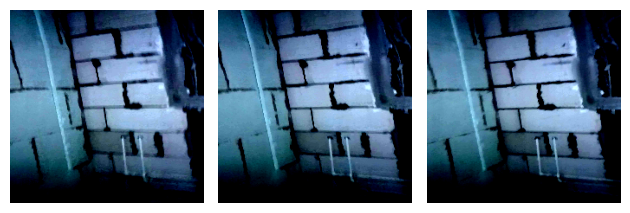

In [73]:
i = 0
for k in batch:
    i += 1
    plt.subplot(1, 3, i)
    plt.imshow(k.permute(1, 2, 0).numpy())  
    plt.axis('off')
    
plt.tight_layout()  
plt.show()  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


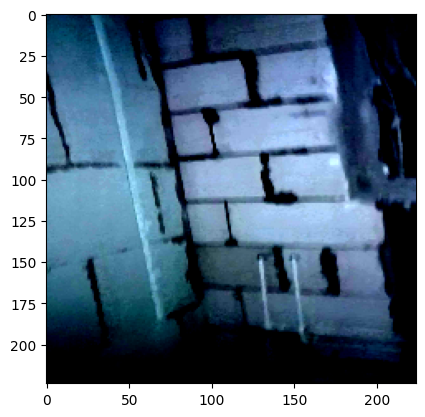

In [26]:
# Предварительно определяем mean и std
# mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
# std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# frame = 0

# cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
# ret, frame = cap.read()
        
# if ret:
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
#     if names[video_path] == 1:
#         frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    
#     frame = (frame / 255.)
#     frame = torch.tensor(frame, dtype=torch.float32) # 1920, 1080, 3
    
#     frame = frame.unsqueeze(0) # 1, 1920, 1080, 3
#     frame = FF.interpolate(einops.rearrange(frame, 'b h w c -> b c h w'), size=(224, 224), 
#                            mode='bicubic', align_corners=False)
#     frame = frame.squeeze(0) # 3, 224, 224
    
#     frame = (frame - mean) / std
#     frame = torch.clamp(frame, 0, 255)  # Ограничиваем значения от 0 до 255
    
# plt.imshow(frame.permute(1, 2, 0).numpy())
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


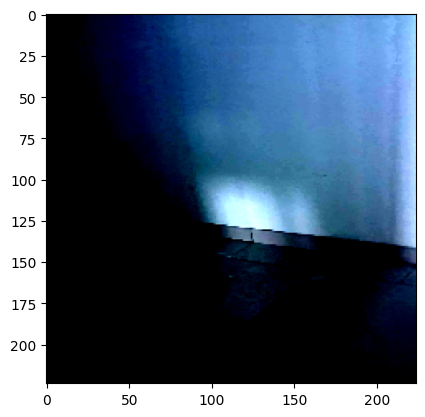

In [14]:
frame = 102

cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
ret, frame = cap.read()
        
if ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    if names[video_path] == 1:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    
    frame = (frame / 255.)
    frame = torch.tensor(frame, dtype=torch.float32) # 1920, 1080, 3
    
    frame = frame.unsqueeze(0) # 1, 1920, 1080, 3
    frame = FF.interpolate(einops.rearrange(frame, 'b h w c -> b c h w'), size=(224, 224), 
                           mode='bicubic', align_corners=False)
    frame = frame.squeeze(0) # 3, 224, 224
    
    frame = (frame - mean) / std
    frame = torch.clamp(frame, 0, 255)  # Ограничиваем значения от 0 до 255
    
plt.imshow(frame.permute(1, 2, 0).numpy())
plt.show()

In [6]:
cap.release()

### Среда

In [7]:
import gym
from gym.spaces import Box, Discrete

class VideoEnv(gym.Env):
    def __init__(self):
        super().__init__()
        # LOW: 0 (LOWER BOUND OF INTERVALS IN ARRAY) (PRESUMABLY COLOR)
        # HIGH: 255 (UPPER BOUND OF INTERVALS IN ARRAY) (PRESUMABLY COLOR)
        
        self.video_dir = "./videos"
        self.videos = os.listdir(self.video_dir)
        self.current_video = 0
        self.cap = cv2.VideoCapture(self.video_dir + "/" + self.videos[self.current_video])
        self.total_videos = len(self.videos)
        
        self.observation_space = Box(low=0, high=1, shape=(3, 3, 224, 224), dtype=np.float32)
        self.current_frame = 0
        self.current_total_frames = self.cap.get(cv2.CAP_PROP_FRAME_COUNT)
        
        # Предварительно определяем mean и std
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        
        # NUMBER OF POSSIBLE ACTIONS: 2 (0 (Go to the +3 frame), 1 (Jamp forward +6))
        self.action_space = Discrete(2)
        
        f = open("./RL_target.txt")
        self.rl_target = json.load(f)

        
    # CAPTURE DESIRED frame
    def get_observation(self, delta=0):
    
        X = []

        for m in range(self.current_frame, self.current_frame + 9, 3):

            self.cap.set(cv2.CAP_PROP_POS_FRAMES, m)
            ret, frame = self.cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                if names[self.videos[self.current_video]] == 1:
                    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

                frame = (frame / 255.)
                frame = torch.tensor(frame, dtype=torch.float32) # 1920, 1080, 3

                X.append(frame) # 1920, 1080, 3

        batch = torch.stack(X, dim=0)
        batch = FF.interpolate(einops.rearrange(batch, 'b h w c -> b c h w'), size=(224, 224), 
                               mode='bicubic', align_corners=False) # 3, 3, 224, 224

        batch = (batch - self.mean) / self.std
        batch = torch.clamp(batch, 0, 255)  # Ограничиваем значения от 0 до 255

        return batch
        
    def step(self, action):
        
        info = {}
        self.dataset_over = False
        reward = 0
        
        neg_reward = -0.1
        pos_reward = 0.1 # 0.4
        discount_3_reward = 1
        
        if (action == 0) & (self.current_frame + 3 < self.current_total_frames):
            
            if self.rl_target[str(self.current_video)][str(self.current_frame)] == 1:
                reward = pos_reward * discount_3_reward
            else:
                reward = neg_reward
            
            self.current_frame += 3
            
            if self.current_frame + 9 >= self.current_total_frames:
                self.increment()
            
            if self.dataset_over:
                self.current_frame -= 3
                next_observation = self.get_observation()
                return next_observation, reward, self.dataset_over, info
            
            next_observation = self.get_observation()
            
        elif (action == 0) & (self.current_frame + 3 >= self.current_total_frames):
            self.increment()
            
            if self.dataset_over:
                reward = 0
                next_observation = self.get_observation()
                return next_observation, reward, self.dataset_over, info
            
            reward = 0
            next_observation = self.get_observation()
        
        # if 0 == 6 then if 0 != 3 then -1 else 1
        # if 0 != 6 then if 0 != 3 then -1 else 1
        if (action == 1) & (self.current_frame + 6 < self.current_total_frames):
            if self.rl_target[str(self.current_video)][str(self.current_frame + 3)] == 0:
                if self.rl_target[str(self.current_video)][str(self.current_frame)] == 1:
                    reward = neg_reward # мониторинг баланса награды
                else:
                    reward = pos_reward
            else:
                if self.rl_target[str(self.current_video)][str(self.current_frame)] == 0:
                    reward = pos_reward
                else:
                    reward = neg_reward
            
            self.current_frame += 6
            
            if self.current_frame + 9 >= self.current_total_frames:
                self.increment()
            
            if self.dataset_over:
                self.current_frame -= 6
                next_observation = self.get_observation()
                return next_observation, reward, self.dataset_over, info
            
            next_observation = self.get_observation()
            
        elif (action == 1) & (self.current_frame + 6 >= self.current_total_frames):
            self.increment()
            
            if self.dataset_over:
                reward = 0
                next_observation = self.get_observation()
                return next_observation, reward, self.dataset_over, info
            
            reward = 0
            next_observation = self.get_observation()
        
        return next_observation, reward, self.dataset_over, info
    
    # RESTART ALL VIDEOS
    def reset(self):
        self.current_video = 0
        self.cap = cv2.VideoCapture(self.videos[self.current_video])
        
        self.current_frame = 0
        self.current_total_frames = self.cap.get(cv2.CAP_PROP_FRAME_COUNT)
        return self.get_observation()
    
    # уловие на завершение последовательности для буффера
    
    # SWITCH TO THE NEW VIDEO
    def increment(self):
        self.current_video += 1
        
        if self.current_video == self.total_videos:
            self.dataset_over = True
            return
        
        self.cap = cv2.VideoCapture(self.video_dir + "/" + self.videos[self.current_video])
        
        self.current_frame = 0
        self.current_total_frames = self.cap.get(cv2.CAP_PROP_FRAME_COUNT)
        return
        
    # VISUALIZE VIDEO ENVIRONMENT
    def render(self):
        # HAVE CV2 SHOW IMAGE
        current_observation = self.get_observation()

        i = 0
        for frame in batch:
            i += 1
            plt.subplot(1, 3, i)
            plt.imshow(frame.permute(1, 2, 0).numpy())  
            plt.axis('off')

        plt.tight_layout()  
        plt.show()  
        
    def close(self):
        self.cap.release()

In [8]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

class RNN_NET(nn.Module):
    def __init__(self, device = "cuda"):
        super().__init__()
        
        self.device = device
        
        model = torch.load(
            './models/models/convnext_base.clip_laion2b_augreg_ft_in12k_in1k_scripted.pt', weights_only=False
        )
                    
        childs = []
        for child in model.children():
            for nested_child in child.children():
                if str(nested_child) not in [
                    "RecursiveScriptModule(original_name=Identity)",
                    "RecursiveScriptModule(original_name=Dropout)",
                    "RecursiveScriptModule(original_name=Linear)"
                ]:
                    childs.append(nested_child)
                    
        self.backbone = nn.Sequential(*childs)
        for p in self.backbone.parameters():
            p.requires_grad = False
        
        self.fc_1 = nn.Linear(1024, 512)
        
        # ────────── Classification head ──────────
        self.rnn = nn.RNN(512, 512, num_layers=1, batch_first=True, bidirectional=False)
        self.fc_2 = nn.Linear(1024, 256)
        self.fc_3 = nn.Linear(256, 2)
        
        self.relu = nn.ReLU()
        
        
    def forward(self, x, hidden_q = None):
        
        back = self.backbone(x)
        
        common_features = self.relu(self.fc_1(back))
        common_features = common_features.unsqueeze(0)
        
        x, hn = self.rnn(common_features, None)
        x_mean = torch.mean(x, dim=1)
        x_max = torch.max(x, dim=1)[0]
        
        x = torch.cat((x_mean, x_max), dim=1)
        
        x = x.squeeze(0)
        
        cls_logits = self.fc_3(self.relu(self.fc_2(x)))

        return cls_logits, back

In [9]:
# Replay Buffer
class RecurrentExperienceReplayMemory:
    def __init__(self, capacity, sequence_length=10):
        self.capacity = capacity
        self.memory = []
        self.seq_length=sequence_length

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self):
        return self.memory

    def __len__(self):
        return len(self.memory)

In [10]:
class BackBoneBody(nn.Module):
    def __init__(self, num_actions, noisy=False, sigma_init=0.5):
        super(BackBoneBody, self).__init__()
        
        self.num_actions = num_actions
        self.noisy=noisy
        
        self.backbone = RNN_NET().to(device)
        self.backbone.load_state_dict(torch.load("./model_18_05_2025.pt"))
        
        for p in self.backbone.parameters():
            p.requires_grad = False

        
    def forward(self, x):
        x, back = self.backbone(x)

        return x, back

In [14]:
class DRQN(nn.Module):
    def __init__(self, num_actions, gru_size=512, bidirectional=False, body=BackBoneBody):
        super(DRQN, self).__init__()
        
        self.num_actions = num_actions
        self.gru_size = gru_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if self.bidirectional else 1

        self.body = body(num_actions)
        self.fc1 = nn.Linear(1024, 512)
        self.gru = nn.RNN(512, 512, num_layers=1, batch_first=True, bidirectional=bidirectional)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(258, self.num_actions)
        self.relu = nn.ReLU()
        
    def forward(self, x, hx=None):
        batch_size = x.size(0)
        sequence_length = x.size(1)
        x = x.squeeze(0) # 10 3 3 224 224
        res_lst = []
        feats_lst = []
        for elem in x: # 3 3 224 224
            res, feats = self.body(elem)
            res_lst.append(res)
            feats_lst.append(feats)
            
        res = torch.stack(res_lst, dim=0) # 10 2
        feats = torch.stack(feats_lst, dim=0) # 10, 3, 1024
        
        feats = feats[:, ::3, :].reshape(sequence_length, 1024) # 10, 1, 1024
        
        common_feats = self.fc1(feats)
        hidden = None # self.init_hidden(batch_size) if hx is None else hx
        common_feats, hidden = self.gru(common_feats, hidden)
        
        common_feats_mean = torch.mean(common_feats, dim=0)
        common_feats_max = torch.max(common_feats, dim=0)[0]
        
        common_feats = torch.cat((common_feats_mean, common_feats_max), dim=-1)
        common_feats = self.fc2(common_feats)
        
#         out = self.fc2(out)
        common_feats = self.relu(torch.cat([res[-1], common_feats], dim=-1))
        out = self.fc3(common_feats)

        return out, hidden, res

#     def init_hidden(self, batch_size):
#         return torch.zeros(1*self.num_directions, self.gru_size, device=device, dtype=torch.float)

In [12]:
class DQN_Agent(object):
    def __init__(self, static_policy=False, env=None, sequence_length=5, EXP_REPLAY_SIZE=1, LR=1e-3, LEARN_START=1,
                 TARGET_NET_UPDATE_FREQ=1, GAMMA=0.99, N_STEPS=1):
        super(DQN_Agent, self).__init__()
        self.device = "cuda"
        
        self.sequence_length=SEQUENCE_LENGTH
        self.seq = [torch.zeros(3, 3, 224, 224) for j in range(self.sequence_length)]
        self.preds = []
        self.preds_probas = []
        self.targets = []

        self.noisy=False
        self.priority_replay=False

        self.gamma = GAMMA
        self.lr = LR
        self.target_net_update_freq = TARGET_NET_UPDATE_FREQ
        self.experience_replay_size = EXP_REPLAY_SIZE
        self.batch_size = 1
        self.learn_start = LEARN_START
        self.update_freq = 1 # 10
        self.sigma_init= 1
        self.priority_beta_start = 1
        self.priority_beta_frames = 1
        self.priority_alpha = 1

        self.static_policy = static_policy
        self.num_feats = env.observation_space.shape
        self.num_actions = env.action_space.n
        self.env = env

        self.declare_networks()
            
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(list(self.model.fc1.parameters()) + \
                                    list(self.model.gru.parameters()) + \
                                    list(self.model.fc2.parameters()) + \
                                    list(self.model.fc3.parameters()), lr=self.lr)
#         self.optimizer = optim.Adam(list(self.model.fc1.parameters()) + \
#                                     list(self.model.fc2.parameters()), lr=self.lr)
        
        #move to correct device
        self.model = self.model.to(self.device)
        self.target_model.to(self.device)

        if self.static_policy:
            self.model.eval()
            self.target_model.eval()
        else:
            self.model.train()
            self.target_model.train()

        self.update_count = 0

        self.declare_memory()

        self.nsteps = N_STEPS
        self.nstep_buffer = []

    def huber(self, x):
        cond = (x.abs() < 1.0).float().detach()
        return 0.5 * x.pow(2) * cond + (x.abs() - 0.5) * (1.0 - cond)
    
    def declare_networks(self):
        self.model = DRQN(self.num_actions, body=BackBoneBody)
        self.target_model = DRQN(self.num_actions, body=BackBoneBody)

    def declare_memory(self):
        self.memory = RecurrentExperienceReplayMemory(self.experience_replay_size, self.sequence_length)

    def append_to_replay(self, s, a, r, s_):
        self.nstep_buffer.append((s, a, r, s_))

        if(len(self.nstep_buffer)<self.nsteps):
            return
        
        R = sum([self.nstep_buffer[h][2]*(self.gamma**(self.nsteps-h)) for h in range(self.nsteps)])

        for g in range(self.nsteps):
            state, action, _, s_ = self.nstep_buffer.pop(0)
            self.memory.push((state, action, R, s_))

    def update(self, s, a, r, s_, frame=0):
        if self.static_policy:
            return None

        self.append_to_replay(s, a, r, s_)

        if frame < self.learn_start or frame % self.update_freq != 0:
            return None

        batch_vars = self.prep_minibatch()

        loss = self.compute_loss(batch_vars)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            if param.grad is not None:
                param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        self.update_target_model()

    def update_target_model(self):
        self.update_count += 1
        self.update_count = self.update_count % self.target_net_update_freq
        if self.update_count == 0:
            print("-------updated")
            self.target_model.load_state_dict(self.model.state_dict())

    def get_max_next_state_action(self, next_states):
        return self.target_model(next_states).max(dim=1)[1].view(-1, 1)
    
    def prep_minibatch(self):
        transitions = self.memory.sample()
        batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)

        shape = (1, self.sequence_length, 3, 3, 224, 224)
        
        batch_state = torch.stack(batch_state, dim=0).view(shape).to(self.device)
        batch_action = torch.tensor(batch_action, device=self.device, dtype=torch.long).view(self.sequence_length, -1)
        batch_reward = torch.tensor(batch_reward, device=self.device, dtype=torch.float).view(self.sequence_length)
        # get set of next states for end of each sequence
        # отбираем последний
        batch_next_state = tuple([batch_next_state[i] for i in range(len(batch_next_state)) if (i+1)%(self.sequence_length)==0])
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=self.device, dtype=torch.uint8)
        non_final_next_states = None
        try: #sometimes all next states are false, especially with nstep returns
            non_final_next_states = batch_next_state[0] # torch.tensor([s for s in batch_next_state if s is not None], device=self.device, dtype=torch.float).unsqueeze(dim=1)
#             non_final_next_states = torch.cat([batch_state[non_final_mask, 1:, :], non_final_next_states], dim=1)
            empty_next_state_values = False
        except:
            empty_next_state_values = True

        return batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values
     
    
    def compute_loss(self, batch_vars):
        global k
        
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values = batch_vars
        
        #estimate
        current_q_values, _, res = self.model(batch_state)
        
        prev_current = current_q_values
        softmax = FF.softmax(current_q_values, dim=0)
        score = softmax[1]
        action = current_q_values.max(0)[1]
        score = score.unsqueeze(0)
        action = action.unsqueeze(0)

        self.preds_probas.extend(score.tolist())
        self.preds.extend(action.tolist())
        
        
        for rew in range(len(batch_reward)):
            if rew == len(batch_reward)-1:
                if float(batch_reward[-1]) > 0:
                    target = int(batch_action[rew])
                else:
                    target = 1 - int(batch_action[rew])
                    
        self.targets.append(target)
                    
        print("current", current_q_values)
        print("score", FF.softmax(current_q_values, dim=0))
        print("my_action", action)
        print("batch_action", batch_action.squeeze())
        print("batch_reward", batch_reward.squeeze())
        print("target", self.targets)
        print("preds", self.preds)

        if k % 10 == 0:
#             print(current_q_values.gather(1, batch_action))
            print("--------------------------------------")
            print("F1", f1_score(self.targets, self.preds))
            print("acc", accuracy_score(self.targets, self.preds))
            if (sum(self.targets) > 0) & (sum(self.targets) < len(self.targets)):
                print("gini", 2 * roc_auc_score(self.targets, self.preds_probas) - 1)
            print("--------------------------------------")
            
        current_q_values = current_q_values.gather(-1, batch_action[-1]).squeeze()
        print("gather", current_q_values)
        
        #target вопросики
        with torch.no_grad():
            max_next_q_values = torch.zeros((self.batch_size, self.sequence_length), device=self.device, dtype=torch.float)
            if not empty_next_state_values:
                non_final_next_states = non_final_next_states.unsqueeze(0)
                non_final_next_states = non_final_next_states.unsqueeze(0)
                max_next, _, res = self.target_model(non_final_next_states.to(self.device))
#                 max_next_q_values[non_final_mask] = max_next.max(dim=1)[0]
                max_next_q_values = max_next.max(dim=0)[0] # values
            expected_q_values = batch_reward + ((0.05**self.nsteps)*max_next_q_values)
        
        print("expected_q_values", expected_q_values)
        diff = (expected_q_values - current_q_values)
        print("diff", diff)
        loss = self.huber(diff)
        
        if k % 20 == 0:
            self.targets = []
            self.preds = []
            self.preds_probas = []
        
#         print("loss", loss)
#         print("FF", FF.cross_entropy(prev_current.unsqueeze(0), torch.tensor(target, dtype=torch.long).unsqueeze(0).to(self.device)))
        return loss # + FF.cross_entropy(prev_current.unsqueeze(0), torch.tensor(target, dtype=torch.long).unsqueeze(0).to(self.device))
    
    
    def get_action(self, s, epsilon):
        with torch.no_grad():
            self.seq.pop(0)
            self.seq.append(s)
            if np.random.binomial(1, epsilon):
                print("model")
#                 X = torch.stack([torch.tensor(x) for x in self.seq], dim=0).view(1, self.sequence_length, 3, 3, 224, 224).to(self.device)
                X = torch.stack(self.seq, dim=0).view(1, self.sequence_length, 3, 3, 224, 224).to(self.device)
                a, _, res = self.model(X)
#                 print(a)
#                 a = a[-1, :] #select last element of seq
                a = a.max(0)[1]
                return a.item()
            else:
                print("random")
                return np.random.randint(0, self.num_actions)

In [70]:
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#epsilon variables
epsilon_start = 0.9
epsilon_final = 0.1
epsilon_decay = 500
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

#misc agent variables
GAMMA=0.99 #99
LR=1e-2
k = 1

#memory
TARGET_NET_UPDATE_FREQ = 5
BATCH_SIZE = 1

#Learning control variables
MAX_FRAMES=350

#Nstep controls
N_STEPS=1

#DRQN Parameters seq
length = 1
EXP_REPLAY_SIZE = length # EXP_REPLAY_SIZE = 10
LEARN_START = length # LEARN_START = 10
SEQUENCE_LENGTH = length # SEQUENCE_LENGTH=10

video_env = VideoEnv()

model = DQN_Agent(static_policy=False, env=video_env, sequence_length=SEQUENCE_LENGTH, EXP_REPLAY_SIZE=EXP_REPLAY_SIZE, LR=LR,
              LEARN_START=LEARN_START, TARGET_NET_UPDATE_FREQ=TARGET_NET_UPDATE_FREQ, GAMMA=GAMMA, N_STEPS=N_STEPS)

observation = video_env.get_observation()
episode_reward = 0

for frame_idx in range(1, MAX_FRAMES + 1):
    print("current_frame", video_env.current_frame)
    epsilon = epsilon_by_frame(frame_idx)
    print(epsilon)
        
    action = model.get_action(observation, epsilon)
    prev_observation=observation
    observation, reward, done, _ = video_env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward
    if k % 30 == 0:
        print("mean_reward", episode_reward / k)
        print()
    k += 1

C:\Users\itolo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


current_frame 0
0.8984015989338665
model
current tensor([ 0.0295, -0.0077], device='cuda:0', grad_fn=<ViewBackward0>)
score tensor([0.5093, 0.4907], device='cuda:0', grad_fn=<SoftmaxBackward0>)
my_action tensor([0], device='cuda:0')
batch_action tensor(0, device='cuda:0')
batch_reward tensor(-0.0990, device='cuda:0')
target [1]
preds [0]
gather tensor(0.0295, device='cuda:0', grad_fn=<SqueezeBackward0>)
expected_q_values tensor([-0.0969], device='cuda:0')
diff tensor([-0.1264], device='cuda:0', grad_fn=<SubBackward0>)
current_frame 3
0.8968063914751933
model
current tensor([-1.3302, -0.1323], device='cuda:0', grad_fn=<ViewBackward0>)
score tensor([0.2319, 0.7681], device='cuda:0', grad_fn=<SoftmaxBackward0>)
my_action tensor([1], device='cuda:0')
batch_action tensor(1, device='cuda:0')
batch_reward tensor(-0.0990, device='cuda:0')
target [1, 0]
preds [0, 1]
gather tensor(-0.1323, device='cuda:0', grad_fn=<SqueezeBackward0>)
expected_q_values tensor([-0.0940], device='cuda:0')
diff tens

current tensor([-0.3741, -0.7929], device='cuda:0', grad_fn=<ViewBackward0>)
score tensor([0.6032, 0.3968], device='cuda:0', grad_fn=<SoftmaxBackward0>)
my_action tensor([0], device='cuda:0')
batch_action tensor(0, device='cuda:0')
batch_reward tensor(0.0990, device='cuda:0')
target [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
preds [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
gather tensor(-0.3741, device='cuda:0', grad_fn=<SqueezeBackward0>)
expected_q_values tensor([0.0772], device='cuda:0')
diff tensor([0.4512], device='cuda:0', grad_fn=<SubBackward0>)
current_frame 81
0.8732572037100054
model
current tensor([-0.3390, -0.7885], device='cuda:0', grad_fn=<ViewBackward0>)
score tensor([0.6105, 0.3895], device='cuda:0', grad_fn=<SoftmaxBackward0>)
my_action tensor([0], device='cuda:0')
batch_action tensor(0, device='cuda:0')
batch_reward tensor(-0.0990, device='cuda:0')
target [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]
preds [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0

current tensor([ 0.0499, -0.1413], device='cuda:0', grad_fn=<ViewBackward0>)
score tensor([0.5477, 0.4523], device='cuda:0', grad_fn=<SoftmaxBackward0>)
my_action tensor([0], device='cuda:0')
batch_action tensor(0, device='cuda:0')
batch_reward tensor(0.0990, device='cuda:0')
target [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
preds [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
--------------------------------------
F1 0.0
acc 0.9
gini -1.0
--------------------------------------
gather tensor(0.0499, device='cuda:0', grad_fn=<SqueezeBackward0>)
expected_q_values tensor([0.1049], device='cuda:0')
diff tensor([0.0549], device='cuda:0', grad_fn=<SubBackward0>)
-------updated
mean_reward 0.006666666666666666

current_frame 126
0.8519063094328712
model


KeyboardInterrupt: 

In [25]:
video_env.close()

In [35]:
%debug

> c:\users\itolo\appdata\local\programs\python\python310\lib\site-packages\torch\nn\functional.py(3494)cross_entropy()
   3492     if size_average is not None or reduce is not None:
   3493         reduction = _Reduction.legacy_get_string(size_average, reduce)
-> 3494     return torch._C._nn.cross_entropy_loss(
   3495         input,
   3496         target,

ipdb> score
*** NameError: name 'score' is not defined
ipdb> input
[0.48886123299598694]
ipdb> target
tensor([1], device='cuda:0')
ipdb> exit()


In [20]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [22]:
model_graph.visual_graph.save("visual_graph.png", "./")

'./visual_graph.png'

In [21]:
dir(model_graph.visual_graph)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_a_list',
 '_attr',
 '_attr_list',
 '_attr_plain',
 '_comment',
 '_copy_kwargs',
 '_default_extension',
 '_edge',
 '_edge_plain',
 '_encoding',
 '_engine',
 '_format',
 '_formatter',
 '_get_filepath',
 '_get_format',
 '_get_parameters',
 '_get_pipe_parameters',
 '_get_render_parameters',
 '_getattr_from_dict',
 '_head',
 '_head_strict',
 '_jupyter_mimetype',
 '_mkdirs',
 '_node',
 '_pipe_future',
 '_pipe_legacy',
 '_pipe_lines',
 '_pipe_lines_string',
 '_quote',
 '_quote_edge',
 '_render',
 '_renderer',
 '_repr_image_jpeg',
 '_repr_image_png',
 '_repr_image_svg_xml',
 '_repr_mimebundle_',

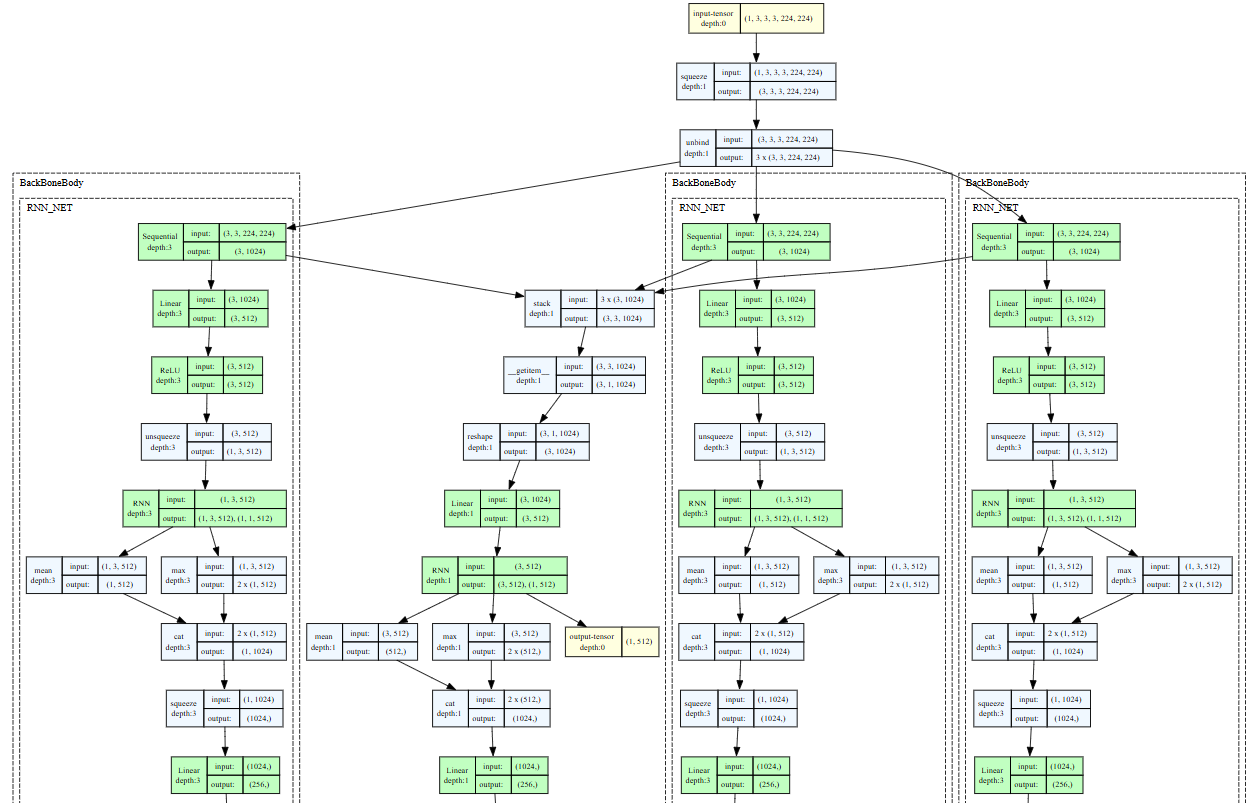

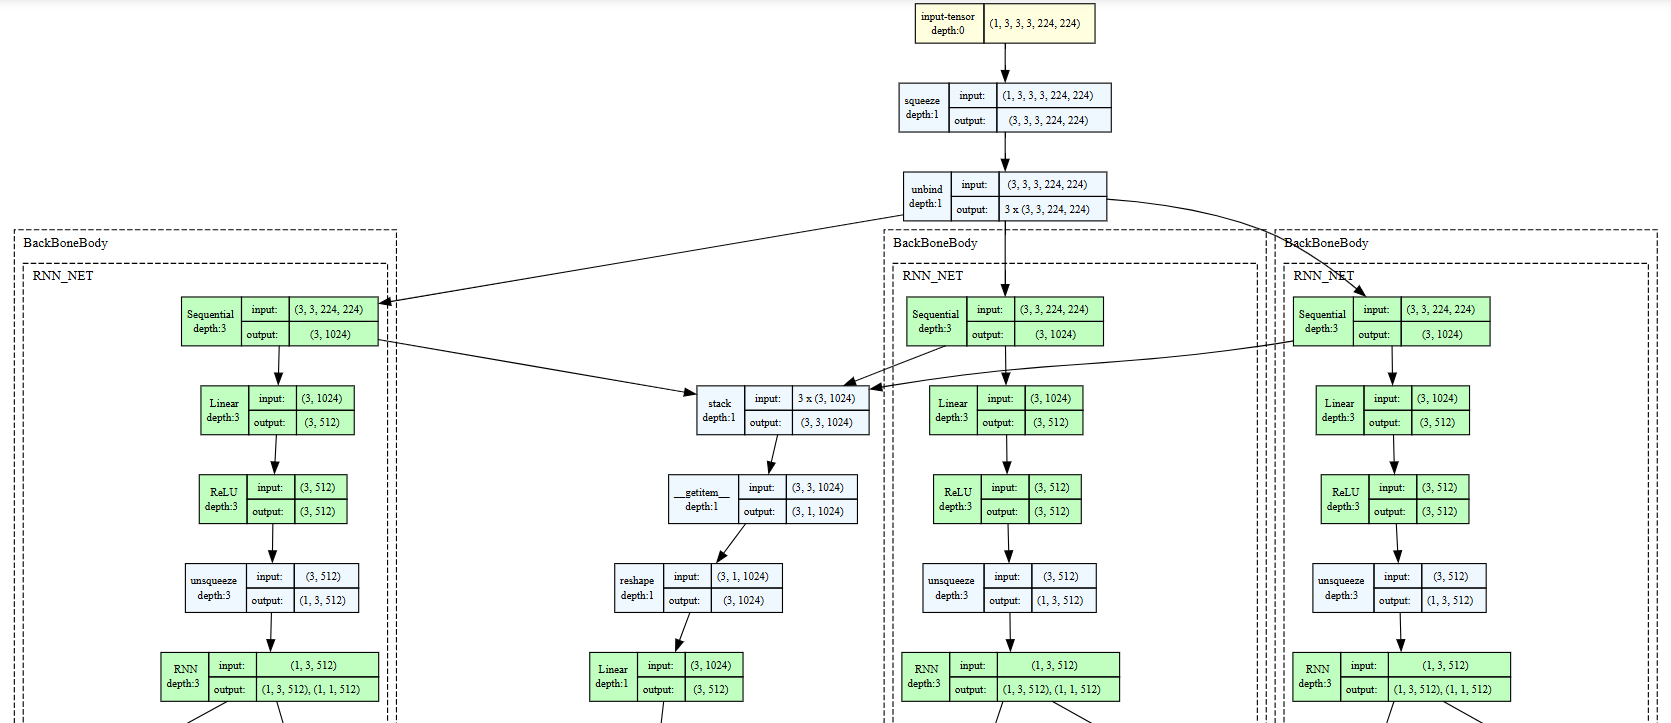

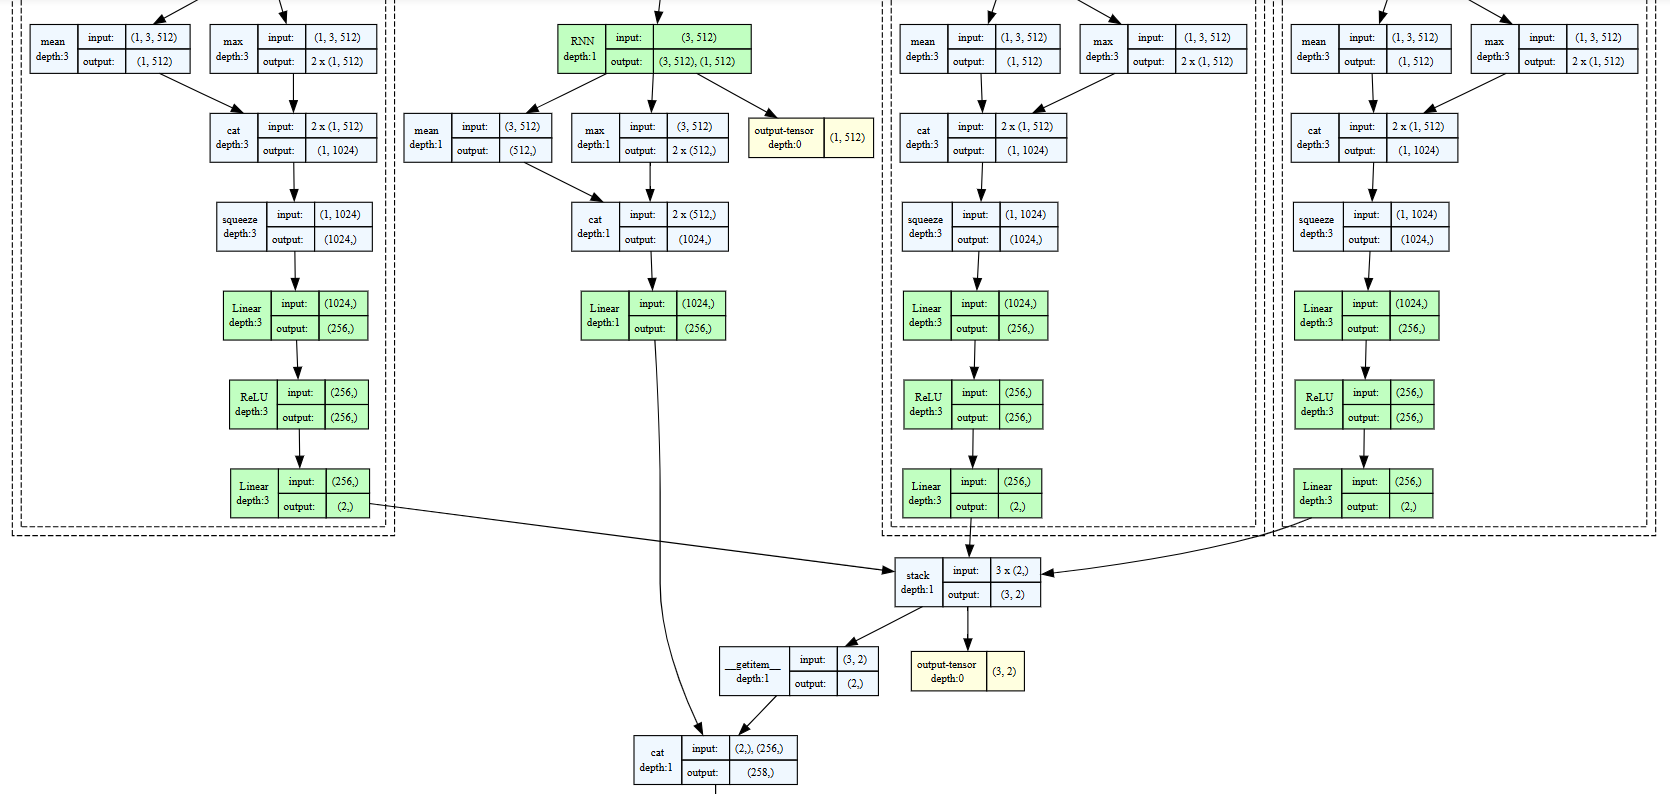

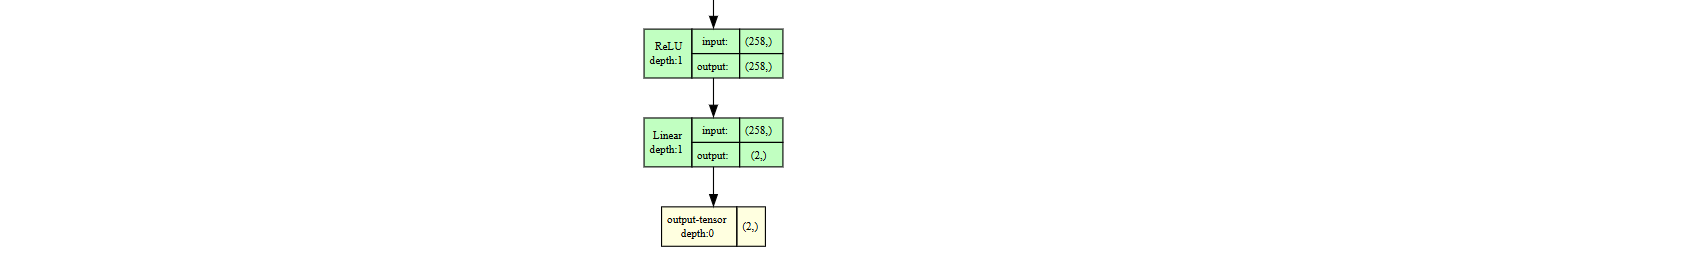


(process:21000): Pango-WARNING **: 14:51:12.864: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


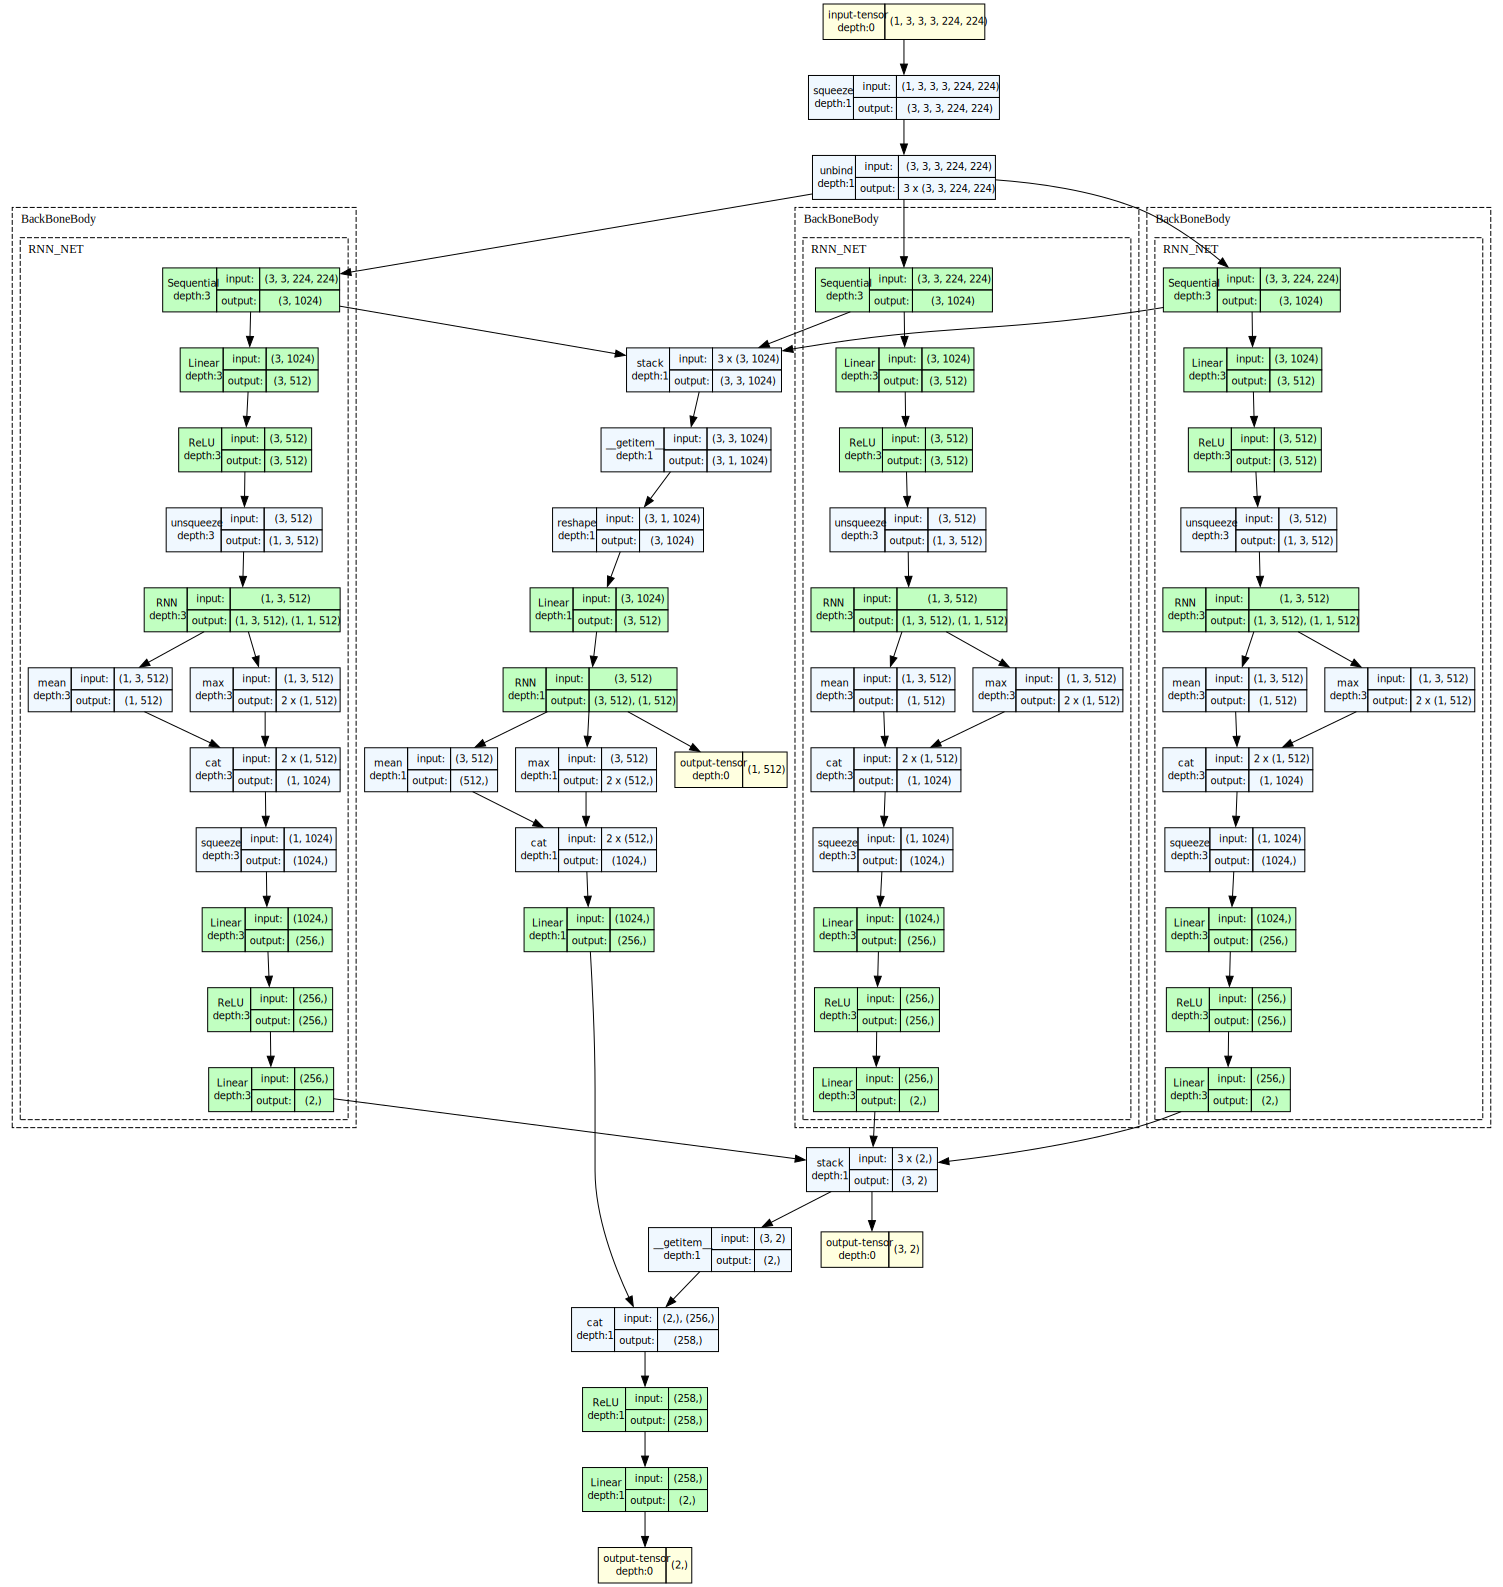

In [19]:
from torchview import draw_graph
device="cuda"

model_graph = draw_graph(DRQN(2), input_size=(1, 3, 3, 3, 224, 224), expand_nested=True)
model_graph.visual_graph

In [ ]:
model.target_model

In [125]:
# torch.save(model.target_model.state_dict(), "./target_model_19_05_2025.pt")

In [39]:
# torch.save(model.target_model.state_dict(), "./target_model_18_05_2025.pt")

In [17]:
model.target_model.eval()

DRQN(
  (body): BackBoneBody(
    (backbone): RNN_NET(
      (backbone): Sequential(
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=LayerNorm2d)
        (2): RecursiveScriptModule(
          original_name=ConvNeXtStage
          (downsample): RecursiveScriptModule(original_name=Identity)
          (blocks): RecursiveScriptModule(
            original_name=Sequential
            (0): RecursiveScriptModule(
              original_name=ConvNeXtBlock
              (conv_dw): RecursiveScriptModule(original_name=Conv2d)
              (norm): RecursiveScriptModule(original_name=LayerNorm)
              (mlp): RecursiveScriptModule(
                original_name=Mlp
                (fc1): RecursiveScriptModule(original_name=Linear)
                (act): RecursiveScriptModule(original_name=GELU)
                (drop1): RecursiveScriptModule(original_name=Dropout)
                (norm): RecursiveScriptModule(original_name=Identity)
  

In [71]:
# inference

video_dir = "./videos"
device="cuda"

video_num = 2 # 17

video_path = os.listdir(video_dir)[video_num]
cap = cv2.VideoCapture(video_dir + "/" + video_path)
cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
hidden = None

f = open("./RL_target.txt")
rl_target = json.load(f)

# Предварительно определяем mean и std
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

targets = []
actions = []
reses = []

l = 0
memory = []
capacity = 1

for i in range(0, int(cnt) - 9, 3):
    
    prev_i = i
    X = []
    
    for j in range(3):
    
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            if names[video_path] == 1:
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

            frame = (frame / 255.)
            frame = torch.tensor(frame, dtype=torch.float32) # 1920, 1080, 3

        X.append(frame)
        i += 3
        
    batch = torch.stack(X, dim=0)
    batch = FF.interpolate(einops.rearrange(batch, 'b h w c -> b c h w'), size=(224, 224), 
                           mode='bicubic', align_corners=False) # 3, 3, 224, 224
    
    batch = (batch - mean) / std
    batch = torch.clamp(batch, 0, 255)  # Ограничиваем значения от 0 до 255
    batch = batch.unsqueeze(0)
    batch = batch.unsqueeze(0)
    
    i = prev_i
    
    memory.append(batch)
    if len(memory) > capacity:
        del memory[0]
            
    if l > capacity:
        
        with torch.no_grad():
            batch = torch.stack(memory, dim=0).view(1, capacity, 3, 3, 224, 224)
            current_q_values, hidden, res = model.target_model(batch.to(device)) # 1, 1, 3, 3, 224, 224
            
            if capacity == 1:
                reses.append(int(res[-1, :].max(0)[1]))
                
#                 score = FF.softmax(current_q_values[-1, :], dim=0)[1]
#                 action = current_q_values[-1, :].max(0)[1]
#                 score = score.unsqueeze(0)
#                 action = action.unsqueeze(0)
            
            else:
                reses.append(int(res[-1, :].max(0)[1]))
                score = FF.softmax(current_q_values, dim=0)[1]
#                 action = current_q_values.argmax(dim=-1)
            
#             reses.append(int(res[-1, :].max(0)[1]))
#             print(current_q_values)
            print(current_q_values)
            action = int(current_q_values.max(0)[1])
            print("action", action)
            actions.append(action)
            target = rl_target[str(video_num)][str(i)]
            if (target == 1) & (action == 0):
                targets.append(1)
            elif (target == 0) & (action == 0):
                targets.append(0)
            elif (target == 1) & (action == 1):
                targets.append(0)
            elif (target == 0) & (action == 1):
                targets.append(1)
            
#         print("frame", i)
#         print(target)
#     print(q_values.shape) # torch.Size([1, 2])
    l += 1
    if i % 30 == 0:
        print()
        print("F1", f1_score(targets, actions))
        print("acc", accuracy_score(targets, actions))
        print()


F1 0.0
acc nan



C:\Users\itolo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\itolo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\itolo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


tensor([ 0.0727, -0.1209], device='cuda:0')
action 0
tensor([ 0.0703, -0.1257], device='cuda:0')
action 0
tensor([ 0.0755, -0.1153], device='cuda:0')
action 0
tensor([ 0.0869, -0.0924], device='cuda:0')
action 0
tensor([ 0.0842, -0.0979], device='cuda:0')
action 0
tensor([ 0.1010, -0.0700], device='cuda:0')
action 0
tensor([ 0.0910, -0.0843], device='cuda:0')
action 0
tensor([ 0.0892, -0.0878], device='cuda:0')
action 0
tensor([ 0.0870, -0.0923], device='cuda:0')
action 0

F1 0.0
acc 0.2222222222222222

tensor([ 0.0924, -0.0813], device='cuda:0')
action 0
tensor([ 0.0876, -0.0910], device='cuda:0')
action 0
tensor([ 0.0879, -0.0906], device='cuda:0')
action 0
tensor([ 0.0820, -0.1022], device='cuda:0')
action 0
tensor([ 0.0948, -0.0783], device='cuda:0')
action 0
tensor([ 0.0935, -0.0799], device='cuda:0')
action 0
tensor([ 0.0800, -0.1064], device='cuda:0')
action 0
tensor([ 0.0822, -0.1020], device='cuda:0')
action 0
tensor([ 0.0885, -0.0893], device='cuda:0')
action 0
tensor([ 0.087

tensor([ 0.0722, -0.1219], device='cuda:0')
action 0
tensor([ 0.0670, -0.1324], device='cuda:0')
action 0
tensor([ 0.0822, -0.1019], device='cuda:0')
action 0
tensor([ 0.0849, -0.0965], device='cuda:0')
action 0

F1 0.01941747572815534
acc 0.3221476510067114

tensor([ 0.0804, -0.1056], device='cuda:0')
action 0
tensor([ 0.0778, -0.1106], device='cuda:0')
action 0
tensor([ 0.0655, -0.1354], device='cuda:0')
action 0
tensor([ 0.0682, -0.1301], device='cuda:0')
action 0
tensor([ 0.0688, -0.1287], device='cuda:0')
action 0
tensor([ 0.0644, -0.1376], device='cuda:0')
action 0
tensor([ 0.0766, -0.1131], device='cuda:0')
action 0
tensor([ 0.0829, -0.1005], device='cuda:0')
action 0
tensor([ 0.0788, -0.1088], device='cuda:0')
action 0
tensor([ 0.0691, -0.1282], device='cuda:0')
action 0

F1 0.01834862385321101
acc 0.3270440251572327

tensor([ 0.0732, -0.1199], device='cuda:0')
action 0
tensor([ 0.0782, -0.1100], device='cuda:0')
action 0
tensor([ 0.0773, -0.1118], device='cuda:0')
action 0
ten

tensor([-2.2891, -0.1798], device='cuda:0')
action 1

F1 0.019230769230769232
acc 0.29411764705882354

tensor([ 0.0988, -0.0730], device='cuda:0')
action 0
tensor([ 0.0967, -0.0757], device='cuda:0')
action 0
tensor([ 0.0845, -0.0973], device='cuda:0')
action 0
tensor([-0.5914, -0.1162], device='cuda:0')
action 1
tensor([-2.0790, -0.1335], device='cuda:0')
action 1
tensor([-0.1129, -0.1080], device='cuda:0')
action 1
tensor([ 0.1036, -0.0666], device='cuda:0')
action 0
tensor([ 0.0927, -0.0810], device='cuda:0')
action 0
tensor([ 0.0795, -0.1073], device='cuda:0')
action 0
tensor([ 0.0775, -0.1114], device='cuda:0')
action 0

F1 0.027777777777777776
acc 0.2976588628762542

tensor([ 0.0856, -0.0951], device='cuda:0')
action 0
tensor([ 0.0723, -0.1217], device='cuda:0')
action 0
tensor([ 0.0830, -0.1003], device='cuda:0')
action 0
tensor([ 0.1012, -0.0697], device='cuda:0')
action 0
tensor([ 0.0916, -0.0831], device='cuda:0')
action 0
tensor([ 0.0863, -0.0937], device='cuda:0')
action 0


tensor([ 0.0802, -0.1058], device='cuda:0')
action 0
tensor([ 0.0854, -0.0956], device='cuda:0')
action 0
tensor([ 0.0799, -0.1066], device='cuda:0')
action 0
tensor([ 0.0973, -0.0749], device='cuda:0')
action 0
tensor([ 0.0838, -0.0987], device='cuda:0')
action 0
tensor([ 0.0696, -0.1272], device='cuda:0')
action 0
tensor([ 0.0692, -0.1280], device='cuda:0')
action 0
tensor([ 0.0779, -0.1106], device='cuda:0')
action 0
tensor([ 0.0726, -0.1211], device='cuda:0')
action 0
tensor([ 0.0655, -0.1354], device='cuda:0')
action 0

F1 0.023880597014925373
acc 0.255125284738041

tensor([ 0.0688, -0.1287], device='cuda:0')
action 0
tensor([ 0.0768, -0.1128], device='cuda:0')
action 0
tensor([ 0.0873, -0.0916], device='cuda:0')
action 0
tensor([ 0.0733, -0.1197], device='cuda:0')
action 0
tensor([ 0.0888, -0.0887], device='cuda:0')
action 0
tensor([ 0.0928, -0.0809], device='cuda:0')
action 0
tensor([ 0.0773, -0.1117], device='cuda:0')
action 0
tensor([ 0.0935, -0.0800], device='cuda:0')
action 

tensor([ 0.0666, -0.1333], device='cuda:0')
action 0
tensor([ 0.0779, -0.1106], device='cuda:0')
action 0
tensor([ 0.0705, -0.1254], device='cuda:0')
action 0
tensor([ 0.0792, -0.1079], device='cuda:0')
action 0
tensor([ 0.0899, -0.0864], device='cuda:0')
action 0
tensor([ 0.0821, -0.1021], device='cuda:0')
action 0
tensor([ 0.0815, -0.1034], device='cuda:0')
action 0

F1 0.017977528089887642
acc 0.2452504317789292

tensor([ 0.0797, -0.1069], device='cuda:0')
action 0
tensor([ 0.0709, -0.1245], device='cuda:0')
action 0
tensor([ 0.0848, -0.0967], device='cuda:0')
action 0
tensor([ 0.0745, -0.1173], device='cuda:0')
action 0
tensor([ 0.0697, -0.1270], device='cuda:0')
action 0
tensor([ 0.0746, -0.1171], device='cuda:0')
action 0
tensor([ 0.0759, -0.1146], device='cuda:0')
action 0
tensor([ 0.0792, -0.1079], device='cuda:0')
action 0
tensor([ 0.0857, -0.0948], device='cuda:0')
action 0
tensor([ 0.0928, -0.0809], device='cuda:0')
action 0

F1 0.017738359201773836
acc 0.24787775891341257



tensor([ 0.0594, -0.1476], device='cuda:0')
action 0
tensor([ 0.0592, -0.1480], device='cuda:0')
action 0
tensor([ 0.0592, -0.1480], device='cuda:0')
action 0
tensor([ 0.0592, -0.1480], device='cuda:0')
action 0
tensor([ 0.0592, -0.1480], device='cuda:0')
action 0

F1 0.01773049645390071
acc 0.22948539638386647

tensor([ 0.0592, -0.1480], device='cuda:0')
action 0
tensor([ 0.0680, -0.1303], device='cuda:0')
action 0
tensor([ 0.0691, -0.1282], device='cuda:0')
action 0
tensor([ 0.0916, -0.0831], device='cuda:0')
action 0
tensor([ 0.0852, -0.0959], device='cuda:0')
action 0
tensor([ 0.0982, -0.0737], device='cuda:0')
action 0
tensor([ 0.1014, -0.0695], device='cuda:0')
action 0
tensor([ 0.1140, -0.0527], device='cuda:0')
action 0
tensor([ 0.1138, -0.0531], device='cuda:0')
action 0
tensor([ 0.1019, -0.0688], device='cuda:0')
action 0

F1 0.0176678445229682
acc 0.23731138545953362

tensor([ 0.1137, -0.0531], device='cuda:0')
action 0
tensor([ 0.1206, -0.0440], device='cuda:0')
action 0
te

KeyboardInterrupt: 

In [ ]:
# какие есть рекомендации по выставлению наград?

In [23]:
sum(reses)

143

In [24]:
len(reses)

194

In [25]:
1 - 143 / 194

0.2628865979381443

In [26]:
sum(actions)

32

In [132]:
1 - 72 / 194

0.6288659793814433

In [92]:
rl_target

{'0': {'0': 0,
  '1': 1,
  '2': 1,
  '3': 1,
  '4': 1,
  '5': 1,
  '6': 1,
  '7': 1,
  '8': 1,
  '9': 1,
  '10': 0,
  '11': 1,
  '12': 1,
  '13': 0,
  '14': 1,
  '15': 1,
  '16': 1,
  '17': 1,
  '18': 0,
  '19': 1,
  '20': 1,
  '21': 1,
  '22': 1,
  '23': 0,
  '24': 1,
  '25': 1,
  '26': 1,
  '27': 1,
  '28': 0,
  '29': 0,
  '30': 1,
  '31': 0,
  '32': 0,
  '33': 0,
  '34': 1,
  '35': 1,
  '36': 1,
  '37': 0,
  '38': 1,
  '39': 0,
  '40': 0,
  '41': 0,
  '42': 0,
  '43': 0,
  '44': 0,
  '45': 0,
  '46': 1,
  '47': 0,
  '48': 0,
  '49': 1,
  '50': 1,
  '51': 1,
  '52': 1,
  '53': 1,
  '54': 0,
  '55': 1,
  '56': 1,
  '57': 1,
  '58': 1,
  '59': 1,
  '60': 1,
  '61': 1,
  '62': 1,
  '63': 1,
  '64': 1,
  '65': 1,
  '66': 0,
  '67': 0,
  '68': 1,
  '69': 0,
  '70': 1,
  '71': 1,
  '72': 0,
  '73': 0,
  '74': 0,
  '75': 1,
  '76': 1,
  '77': 1,
  '78': 1,
  '79': 1,
  '80': 0,
  '81': 0,
  '82': 1,
  '83': 1,
  '84': 1,
  '85': 1,
  '86': 1,
  '87': 1,
  '88': 1,
  '89': 1,
  '90': 1,
  '9

### Actor Critic

In [4]:
import gym
from gym.spaces import Box, Discrete

class VideoEnv(gym.Env):
    def __init__(self):
        super().__init__()
        # LOW: 0 (LOWER BOUND OF INTERVALS IN ARRAY) (PRESUMABLY COLOR)
        # HIGH: 255 (UPPER BOUND OF INTERVALS IN ARRAY) (PRESUMABLY COLOR)
        
        self.video_dir = "./videos"
        self.videos = os.listdir(self.video_dir)
        self.current_video = 0
        self.cap = cv2.VideoCapture(self.video_dir + "/" + self.videos[self.current_video])
        self.total_videos = len(self.videos)
        
        self.observation_space = Box(low=0, high=1, shape=(3, 3, 224, 224), dtype=np.float32)
        self.current_frame = 0
        self.current_total_frames = self.cap.get(cv2.CAP_PROP_FRAME_COUNT)
        
        # Предварительно определяем mean и std
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        
        # NUMBER OF POSSIBLE ACTIONS: 2 (0 (Go to the +3 frame), 1 (Jamp forward +6))
        self.action_space = Discrete(2)
        
        f = open("./RL_target.txt")
        self.rl_target = json.load(f)

        
    # CAPTURE DESIRED frame
    def get_observation(self, delta=0):
    
        X = []

        for m in range(self.current_frame, self.current_frame + 9, 3):

            self.cap.set(cv2.CAP_PROP_POS_FRAMES, m)
            ret, frame = self.cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                if names[self.videos[self.current_video]] == 1:
                    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

                frame = (frame / 255.)
                frame = torch.tensor(frame, dtype=torch.float32) # 1920, 1080, 3

                X.append(frame) # 1920, 1080, 3

        batch = torch.stack(X, dim=0)
        batch = FF.interpolate(einops.rearrange(batch, 'b h w c -> b c h w'), size=(224, 224), 
                               mode='bicubic', align_corners=False) # 3, 3, 224, 224

        batch = (batch - self.mean) / self.std
        batch = torch.clamp(batch, 0, 255)  # Ограничиваем значения от 0 до 255

        return batch
        
    def step(self, actions):
        
        info = {}
        self.dataset_over = False
        reward = 0
        
        neg_reward = -0.1
        pos_reward = 0.1 # 0.4
        discount_3_reward = 1
        
        next_observations, rewards, dataset_overs, infos = [], [], [], []
        
        for action in actions:
            
            if action == 2:
                action = 1 # поправить
        
            if (action == 0) & (self.current_frame + 3 < self.current_total_frames):

                if self.rl_target[str(self.current_video)][str(self.current_frame)] == 1:
                    reward = pos_reward * discount_3_reward
                else:
                    reward = neg_reward

                self.current_frame += 3

                if self.current_frame + 9 >= self.current_total_frames:
                    self.increment()

                if self.dataset_over:
                    self.current_frame -= 3
                    next_observation = self.get_observation()
                    
                    next_observations.append(next_observation)
                    rewards.append(reward)
                    dataset_overs.append(self.dataset_over)
                    infos.append(info)
                    continue

                next_observation = self.get_observation()
                next_observations.append(next_observation)
                rewards.append(reward)

            elif (action == 0) & (self.current_frame + 3 >= self.current_total_frames):
                self.increment()

                if self.dataset_over:
                    reward = 0
                    next_observation = self.get_observation()
                    
                    next_observations.append(next_observation)
                    rewards.append(reward)
                    dataset_overs.append(self.dataset_over)
                    infos.append(info)
                    continue

                reward = 0
                next_observation = self.get_observation()
                next_observations.append(next_observation)
                rewards.append(reward)

            # if 0 == 6 then if 0 != 3 then -1 else 1
            # if 0 != 6 then if 0 != 3 then -1 else 1
            if (action == 1) & (self.current_frame + 6 < self.current_total_frames):
                if self.rl_target[str(self.current_video)][str(self.current_frame + 3)] == 0:
                    if self.rl_target[str(self.current_video)][str(self.current_frame)] == 1:
                        reward = neg_reward # мониторинг баланса награды
                    else:
                        reward = pos_reward
                else:
                    if self.rl_target[str(self.current_video)][str(self.current_frame)] == 0:
                        reward = pos_reward
                    else:
                        reward = neg_reward

                self.current_frame += 6

                if self.current_frame + 9 >= self.current_total_frames:
                    self.increment()

                if self.dataset_over:
                    self.current_frame -= 6
                    next_observation = self.get_observation()
                    
                    next_observations.append(next_observation)
                    rewards.append(reward)
                    dataset_overs.append(self.dataset_over)
                    infos.append(info)
                    continue

                next_observation = self.get_observation()
                next_observations.append(next_observation)
                rewards.append(reward)

            elif (action == 1) & (self.current_frame + 6 >= self.current_total_frames):
                self.increment()

                if self.dataset_over:
                    reward = 0
                    next_observation = self.get_observation()
                    
                    next_observations.append(next_observation)
                    rewards.append(reward)
                    dataset_overs.append(self.dataset_over)
                    infos.append(info)
                    continue

                reward = 0
                next_observation = self.get_observation()
                next_observations.append(next_observation)
                rewards.append(reward)
                
            dataset_overs.append(self.dataset_over)
            infos.append(info)
        
        return next_observations, rewards, dataset_overs, infos
    
    # RESTART ALL VIDEOS
    def reset(self):
        self.current_video = 0
        self.cap = cv2.VideoCapture(self.videos[self.current_video])
        
        self.current_frame = 0
        self.current_total_frames = self.cap.get(cv2.CAP_PROP_FRAME_COUNT)
        return self.get_observation()
    
    # уловие на завершение последовательности для буффера
    
    # SWITCH TO THE NEW VIDEO
    def increment(self):
        self.current_video += 1
        
        if self.current_video == self.total_videos:
            self.dataset_over = True
            return
        
        self.cap = cv2.VideoCapture(self.video_dir + "/" + self.videos[self.current_video])
        
        self.current_frame = 0
        self.current_total_frames = self.cap.get(cv2.CAP_PROP_FRAME_COUNT)
        return
        
    # VISUALIZE VIDEO ENVIRONMENT
    def render(self):
        # HAVE CV2 SHOW IMAGE
        current_observation = self.get_observation()

        i = 0
        for frame in batch:
            i += 1
            plt.subplot(1, 3, i)
            plt.imshow(frame.permute(1, 2, 0).numpy())  
            plt.axis('off')

        plt.tight_layout()  
        plt.show()  
        
    def close(self):
        self.cap.release()

In [5]:
class RolloutStorage(object):
    def __init__(self, num_steps, num_processes, obs_shape, action_space, device):
        self.observations = torch.zeros(num_steps + 1, num_processes, *obs_shape).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.value_preds = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.action_log_probs = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(num_steps, num_processes, 1).to(device, torch.long)
        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)

        self.num_steps = num_steps
        self.step = 0

    def insert(self, current_obs, action, action_log_prob, value_pred, reward, mask):
        self.observations[self.step + 1].copy_(current_obs)
        self.actions[self.step].copy_(action)
        self.action_log_probs[self.step].copy_(action_log_prob)
        self.value_preds[self.step].copy_(value_pred)
        self.rewards[self.step].copy_(reward)
        self.masks[self.step + 1].copy_(mask)

        self.step = (self.step + 1) % self.num_steps

    def after_update(self):
        self.observations[0].copy_(self.observations[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value, gamma):
#         print(self.returns.shape)
        self.returns[:-1] = next_value.reshape(3, 16, 1) # self.returns[-1]
#         print(self.returns.shape)
        for step in reversed(range(self.rewards.size(0))):
            self.returns[step] = self.returns[step + 1] * \
                gamma * self.masks[step + 1] + self.rewards[step]

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ActorCritic, self).__init__()

        init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
                    lambda x: nn.init.constant_(x, 0),
                    nn.init.calculate_gain('relu'))
        
        model = torch.load(
            './models/models/convnext_base.clip_laion2b_augreg_ft_in12k_in1k_scripted.pt', weights_only=False
        )
                    
        childs = []
        for child in model.children():
            for nested_child in child.children():
                if str(nested_child) not in [
                    "RecursiveScriptModule(original_name=Identity)",
                    "RecursiveScriptModule(original_name=Dropout)",
                    "RecursiveScriptModule(original_name=Linear)"
                ]:
                    childs.append(nested_child)
                    
        self.backbone = nn.Sequential(*childs)
        for p in self.backbone.parameters():
            p.requires_grad = False
        
        self.fc1 = nn.Linear(1024, 512)
#         self.fc1 = init_(nn.Linear(1024, 512))

#         init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
#           lambda x: nn.init.constant_(x, 0))

#         self.critic_linear = init_(nn.Linear(512, 1))
        self.critic_linear = nn.Linear(512, 1)

#         init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
#               lambda x: nn.init.constant_(x, 0), gain=0.01)

#         self.actor_linear = init_(nn.Linear(512, num_actions))
        self.actor_linear = nn.Linear(512, 2)

        self.train()

    def forward(self, inputs):
        logits = []
        values = []
        for tensor in inputs:
            x = self.backbone(tensor) # 16, 12, 3, 224, 224
            x = x.view(x.size(0), -1)

            x = FF.relu(self.fc1(x))

            value = self.critic_linear(x)
            logit = self.actor_linear(x)
            
            logits.append(logit)
            values.append(value)
        
        return torch.stack(logits, dim=0), torch.stack(values, dim=0)

#     def feature_size(self, input_shape):
#         return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))).view(1, -1).size(1)

#     def layer_init(self, module, weight_init, bias_init, gain=1):
#         weight_init(module.weight.data, gain=gain)
#         bias_init(module.bias.data)
#         return module

In [66]:
class BaseAgent(object):
    def __init__(self, static_policy=False, env=None, device="cuda", noisy=False, priority_replay=False, gamma = 0.99,
              lr = 7e-4, target_net_update_freq = 20, learn_start=10, sigma_init = 1, num_agents = 2,
              value_loss_weight = 0.5, entropy_loss_weight=0.01, rollout=3):
        self.model=None
        self.target_model=None
        self.optimizer = None

        self.rewards = []

        self.action_log_frequency = 1 # ACTION_SELECTION_COUNT_FREQUENCY
        self.action_selections = [0 for _ in range(env.action_space.n)]
        
        self.device = device

        self.noisy=noisy
        self.priority_replay=priority_replay

        self.gamma = gamma
        self.lr = lr
        self.target_net_update_freq = target_net_update_freq
        self.learn_start = learn_start
        self.sigma_init = sigma_init
        self.num_agents = num_agents
        self.value_loss_weight = value_loss_weight
        self.entropy_loss_weight = entropy_loss_weight
        self.rollout = rollout
        self.grad_norm_max = 1

        self.static_policy = static_policy
        self.num_feats = env.observation_space.shape
        self.num_feats = (self.num_feats[0], *self.num_feats[1:])
        self.num_actions = env.action_space.n
        self.env = env

        self.declare_networks()
            
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99, eps=1e-5)
        
        #move to correct device
        self.model = self.model.to(self.device)

        if self.static_policy:
            self.model.eval()
        else:
            self.model.train()

        self.rollouts = RolloutStorage(self.rollout, self.num_agents,
            self.num_feats, self.env.action_space, self.device)

        self.value_losses = []
        self.entropy_losses = []
        self.policy_losses = []

    def huber(self, x):
        cond = (x.abs() < 1.0).float().detach()
        return 0.5 * x.pow(2) * cond + (x.abs() - 0.5) * (1.0 - cond)

    def MSE(self, x):
        return 0.5 * x.pow(2)

    def save_w(self):
        torch.save(self.model.state_dict(), './RL_Examples/model.dump')
        torch.save(self.optimizer.state_dict(), './RL_Examples/optim.dump')
    
    def load_w(self):
        fname_model = "./RL_Examples/model.dump"
        fname_optim = "./RL_Examples/optim.dump"

        if os.path.isfile(fname_model):
            self.model.load_state_dict(torch.load(fname_model))
            self.target_model.load_state_dict(self.model.state_dict())

        if os.path.isfile(fname_optim):
            self.optimizer.load_state_dict(torch.load(fname_optim))

    def save_replay(self):
        pickle.dump(self.memory, open('./RL_Examples/exp_replay_agent.dump', 'wb'))

    def load_replay(self):
        fname = './RL_Examples/exp_replay_agent.dump'
        if os.path.isfile(fname):
            self.memory = pickle.load(open(fname, 'rb'))

    def save_sigma_param_magnitudes(self, tstep):
        with torch.no_grad():
            sum_, count = 0.0, 0.0
            for name, param in self.model.named_parameters():
                if param.requires_grad and 'sigma' in name:
                    sum_+= torch.sum(param.abs()).item()
                    count += np.prod(param.shape)

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_action(self, action, tstep):
        self.action_selections[int(action)] += 1.0/self.action_log_frequency
        if (tstep+1) % self.action_log_frequency == 0:
            with open(os.path.join('./RL_Examples/action_log.csv'), 'a') as f:
                writer = csv.writer(f)
                writer.writerow(list([tstep]+self.action_selections))
            self.action_selections = [0 for _ in range(len(self.action_selections))]
            
            
    def declare_networks(self):
        self.model = ActorCritic(self.num_feats, self.num_actions)

    def get_action(self, s, deterministic=False): # все верно
        logits, values = self.model(s)
        dist = torch.distributions.Categorical(logits=logits) # 16, 3, 2
#         print(dist.probs)
        if deterministic:
            actions = dist.probs.argmax(dim=2, keepdim=True) # 16, 1, 2
        else:
            print("view")
            actions = dist.sample().view(-1, 1)
#         print(actions)
        log_probs = FF.log_softmax(logits, dim=2)
        action_log_probs = log_probs.gather(0, actions)

        return values, actions, action_log_probs
        

    def evaluate_actions(self, s, actions):
        logits, values = self.model(s)
        dist = torch.distributions.Categorical(logits=logits) # 48, 3, 2
#         print(actions.shape) # 48, 1
        log_probs = FF.log_softmax(logits, dim=2)[:,-1,:]
        print(log_probs.shape)
        action_log_probs = log_probs.gather(0, actions)

        dist_entropy = dist.entropy().mean()

        return values, action_log_probs, dist_entropy

    def get_values(self, s):
        _, values = self.model(s)

        return values

    def compute_loss(self, rollouts):
        obs_shape = rollouts.observations.size()[2:] # 3, 3, 224, 224
#         print("rollouts.observations", rollouts.observations.shape)
        action_shape = rollouts.actions.size()[-1] # 3, 3, 224, 224
#         print("rollouts.actions", rollouts.actions.shape)
        num_steps, num_processes, _ = rollouts.rewards.size()

        values, action_log_probs, dist_entropy = self.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        values = values[:,1,:].view(num_steps, num_processes, 1)
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values
        value_loss = advantages.pow(2).mean()

        action_loss = -(advantages.detach() * action_log_probs).mean()

        loss = action_loss + self.value_loss_weight * value_loss - self.entropy_loss_weight * dist_entropy

        return loss, action_loss, value_loss, dist_entropy

    def update(self, rollout):
        loss, action_loss, value_loss, dist_entropy = self.compute_loss(rollout)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_norm_max)
        self.optimizer.step()

        #self.save_loss(loss.item(), action_loss.item(), value_loss.item(), dist_entropy.item())
        #self.save_sigma_param_magnitudes()

        return value_loss.item(), action_loss.item(), dist_entropy.item()

In [70]:
#a2c control
num_agents=16
rollout=3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of updates in 10000000 frames
MAX_FRAMES=int(1e7 / num_agents / rollout)

seed = 1
GAMMA = 0.99

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# torch.set_num_threads(1)

envs = VideoEnv()

# envs = [make_env_a2c_atari(env_id, seed, i, log_dir) for i in range(config.num_agents)]
# envs = SubprocVecEnv(envs) if config.num_agents > 1 else DummyVecEnv(envs)

obs_shape = envs.observation_space.shape
        
model = BaseAgent(env=envs, device=device, noisy=False, priority_replay=False, gamma = GAMMA,
              lr = 7e-4, target_net_update_freq = 20, learn_start=10, sigma_init = 1, num_agents = num_agents,
              value_loss_weight = 0.5, entropy_loss_weight=0.01, rollout=rollout)

current_obs = torch.zeros((num_agents, *obs_shape), device=device, dtype=torch.float32)

def update_current_obs(obs):
    shape_dim0 = envs.observation_space.shape[0]
    obs = obs.to(device)
    current_obs[:, :-shape_dim0] = current_obs[:, shape_dim0:]
    current_obs[:, -shape_dim0:] = obs

obs = envs.get_observation()
update_current_obs(obs)
model.rollouts.observations[0].copy_(current_obs)

episode_rewards = np.zeros(num_agents, dtype=np.float32)
final_rewards = np.zeros(num_agents, dtype=np.float32)

# start=timer()

print_step = 1
print_threshold = 10

for frame_idx in range(1, int(MAX_FRAMES // 1000) +1):
    for step in range(rollout):
        with torch.no_grad():
            values, actions, action_log_prob = model.get_action(model.rollouts.observations[step], deterministic=True)
#             print("actions", actions.shape)
#         print(action_log_prob.shape)
#         print(actions.shape)
        cpu_actions = actions[:,-1,:].view(-1).cpu().numpy()
        print(cpu_actions)
#         print(cpu_actions)

        obs, reward, done, _ = envs.step(cpu_actions)
        episode_rewards += reward
        masks = 1. - np.array(done).astype(np.float32)
        final_rewards *= masks
        final_rewards += episode_rewards
        episode_rewards *= masks

        rewards = torch.from_numpy(np.array(reward).astype(np.float32)).view(-1, 1).to(device)
        print(rewards)
        masks = torch.from_numpy(masks).to(device).view(-1, 1)

        current_obs *= masks.view(-1, 1, 1, 1, 1)
        update_current_obs(torch.stack(obs, dim=0))

        model.rollouts.insert(current_obs, actions[:,-1,:].view(-1, 1), action_log_prob[:,-1,:], values[:,-1,:], rewards, masks)

    with torch.no_grad():
        next_value = model.get_values(model.rollouts.observations[-1])
#         print("next_value", next_value.shape)

    model.rollouts.compute_returns(next_value, GAMMA)

    value_loss, action_loss, dist_entropy = model.update(model.rollouts)

    model.rollouts.after_update()

    if frame_idx % 100 == 0:
        try:
            clear_output()
            total_num_steps = (frame_idx + 1) * num_agents * rollout
            print("Updates {}, Num Timesteps {}, FPS {},\nMean/Median Reward {:.1f}/{:.1f}, Min/Max Reward {:.1f}/{:.1f},\nEntropy {:.5f}, Value Loss {:.5f}, Policy Loss {:.5f}".
            format(frame_idx, total_num_steps,
                   int(total_num_steps / (end - start)),
                   np.mean(final_rewards),
                   np.median(final_rewards),
                   np.min(final_rewards),
                   np.max(final_rewards), dist_entropy,
                   value_loss, action_loss))
        except IOError:
            pass

model.save_w()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tensor([[-0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [-0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [-0.1000],
        [ 0.1000],
        [-0.1000],
        [-0.1000],
        [-0.1000]], device='cuda:0')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tensor([[-0.1000],
        [ 0.1000],
        [-0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [-0.1000],
        [-0.1000],
        [-0.1000],
        [ 0.1000],
        [ 0.1000],
        [-0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000]], device='cuda:0')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tensor([[ 0.1000],
        [-0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [-0.1000],
       

KeyboardInterrupt: 

In [58]:
%debug

> c:\users\itolo\appdata\local\temp\ipykernel_27360\1317049560.py(59)<module>()

ipdb> reward
[-0.1, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.1, -0.1, -0.1, -0.1, -0.1, 0.1, -0.1, 0.1, 0.1, 0.1, -0.1, -0.1, -0.1, 0.1, 0.1, -0.1, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, -0.1, 0.1, -0.1]
ipdb> episode_reward
*** NameError: name 'episode_reward' is not defined
ipdb> episode_rewards
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)
ipdb> exit()


In [ ]:
self.returns[:-1] = next_value.reshape(3, 16, 1)

In [126]:
192/16

12.0